## Graph Analysis Codes for Concept Maps
*ver-1.0.0*

**This program is designed to run in `Windows` env.**

(Still working on adding other domains.)

Requirements:
- Pandas
- Matplotlib
- NetworkX

#### Load packages

In [25]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

#### Methods for individual metrics
1. `num_of_concepts`: 노드 개수와 동일
2. `num_of_relationships`: 엣지 개수와 동일
3. `num_of_hierarchies`
4. `num_of_crosslinks`
5. `cal_aspl`: Average shortest path length
6. `cal_cc`: Clustering coefficient
7. `cal_network_density`
8. `cal_complexity`
9. `get_level_deepest_hierarchy`

In [26]:
def num_of_concepts(G):
    return G.number_of_nodes()

def num_of_relationships(G):
    return G.number_of_edges()

def num_of_hierarchies(G):
    return nx.number_of_strongly_connected_components(G)

def num_of_crosslinks(G):
    return num_of_relationships(G) - num_of_concepts(G) + num_of_hierarchies(G)

def cal_aspl(G):
    try :
        return nx.average_shortest_path_length(G)
    except nx.exception.NetworkXError:
        print("Error: Graph is not connected")
        return 0

def cal_cc(G):
    return nx.average_clustering(G)

def cal_network_density(G):
    return nx.density(G)

def cal_complexity(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    return (E / N) if (N > 0) else 0

def get_level_deepest_hierarchy(G):
    return max([len(nx.shortest_path(G, source, target)) for source in G for target in G])

#### Load data

In [27]:
# This is a sample for entire analysis
data_astrom1 = pd.read_excel('data/Astronomy.xlsx', sheet_name='강민철')
data_astrom2 = pd.read_excel('data/Astronomy.xlsx', sheet_name='강지헌')

# Drop an useless column
data_astrom1.drop('Name', axis=1, inplace=True)
data_astrom2.drop('Name', axis=1, inplace=True)

# In real case, we should merge all dataframes into one dataframe:
# data_astrom = pd.concat([data_astrom1, data_astrom2], axis=1)

,ID,Mod.,Start,End,P.Knowledge
0,1,Web,태양계,"지구형행성,목성형행성",O
1,1,Web,지구형행성,"수성,금성,지구,화성",O
2,1,Web,목성형행성,"목성,토성,천왕성,해왕성",O
3,1,Web,수성,NaN,O
4,1,Web,금성,NaN,O
...,...,...,...,...,...
1493,52,Book,목성,NaN,O
1494,52,Book,토성,NaN,O
1495,52,Book,천왕성,NaN,O
1496,52,Book,해왕성,NaN,O


#### Process graphs
- 이름 형식: `<Domain>_<Modality>_<ID>`
- Domain: `ASTRONOMY`, `SAMPLING`, `DATABASE`

***참고사항**:
    혹시 몰라 노드에 P.Knowledge를 추가로 라벨링해두었지만, 분석할 때는 그냥 df상에서도 충분히 가능해보임*

In [28]:
from enum import Enum

class Domain(Enum):
    ASTRONOMY = "Astronomy"
    SAMPLING = "Sampling"
    DATABASE = "Database"

In [29]:
graphs_astrom = {}

for id, sub_df in data_astrom1.groupby('ID'):
    # New graph object
    graph_name = f"Astronomy_{sub_df['Mod.'].iloc[0]}_{sub_df['ID'].iloc[0]}"
    G = nx.DiGraph()
    
    # Add nodes and edges
    for _, row in sub_df.iterrows():
        start_node = row['Start']
        if pd.notna(row['End']):
            end_nodes = [end_node.rstrip() for end_node in row['End'].split(',')]
            for end_node in end_nodes:
                G.add_edge(start_node, end_node)
        # Add p.knowledge labels:  O -> 1(true)  |  X -> 0(false)
        try:
            G.nodes[start_node]['P.Knowledge'] = 1 if row['P.Knowledge'] == 'O' else 0
        except KeyError:
            G.add_node(start_node)
            G.nodes[start_node]['P.Knowledge'] = 0
    
    # Save the graph
    graphs_astrom[graph_name] = G

#### Draw graphs

In [30]:
# Set Korean font
import matplotlib.font_manager as fm 
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

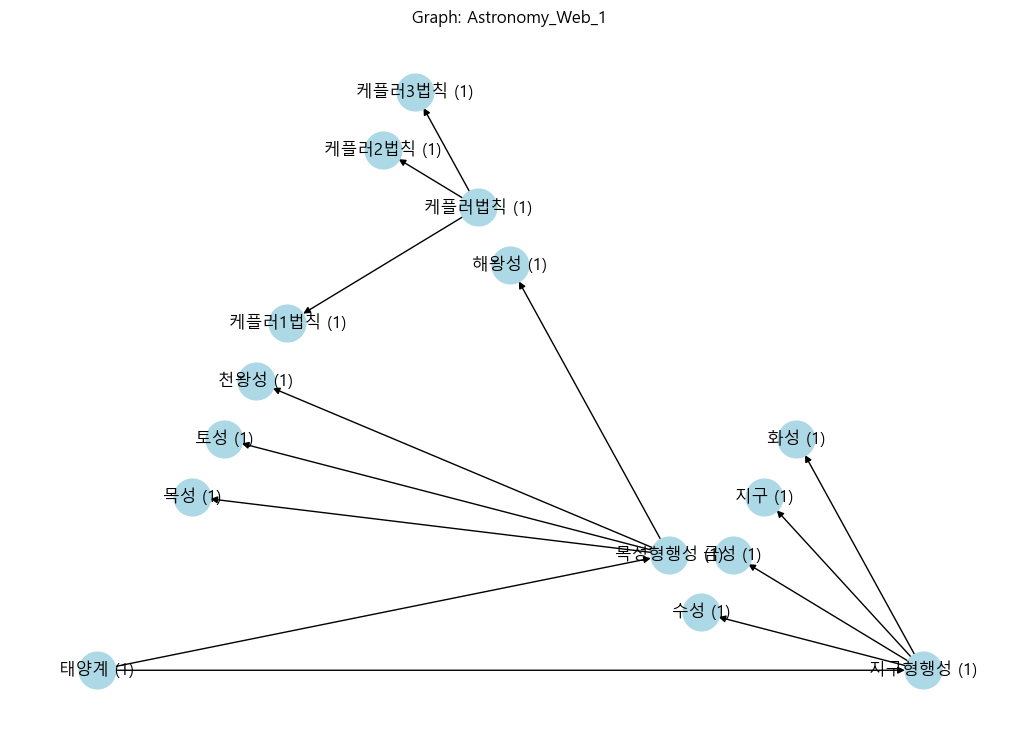

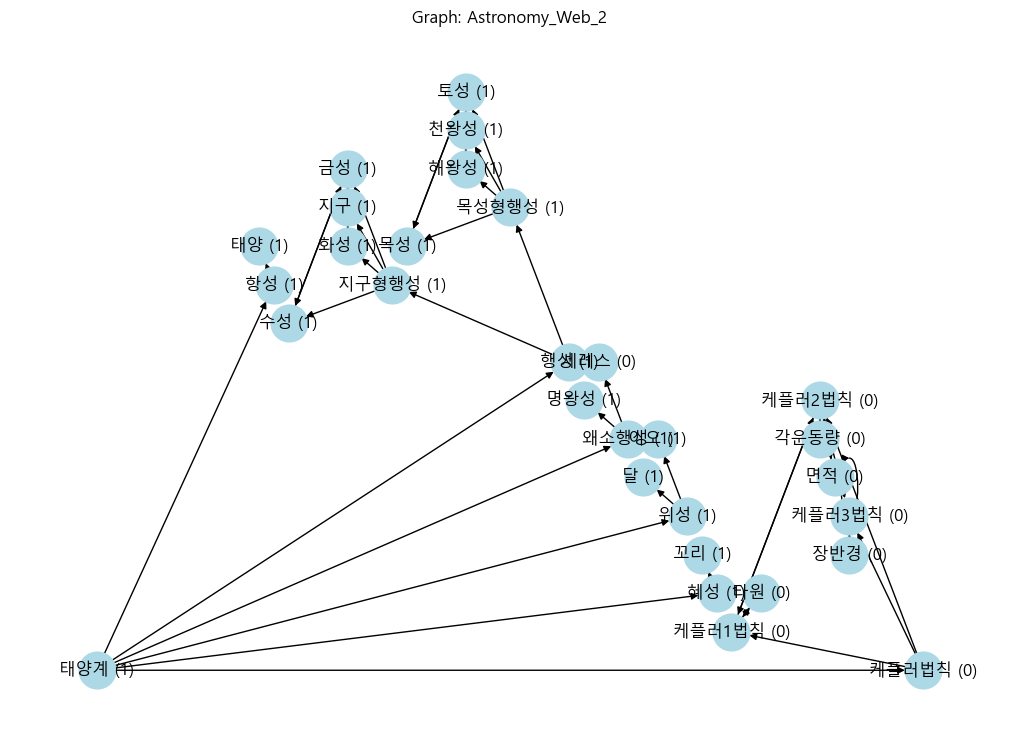

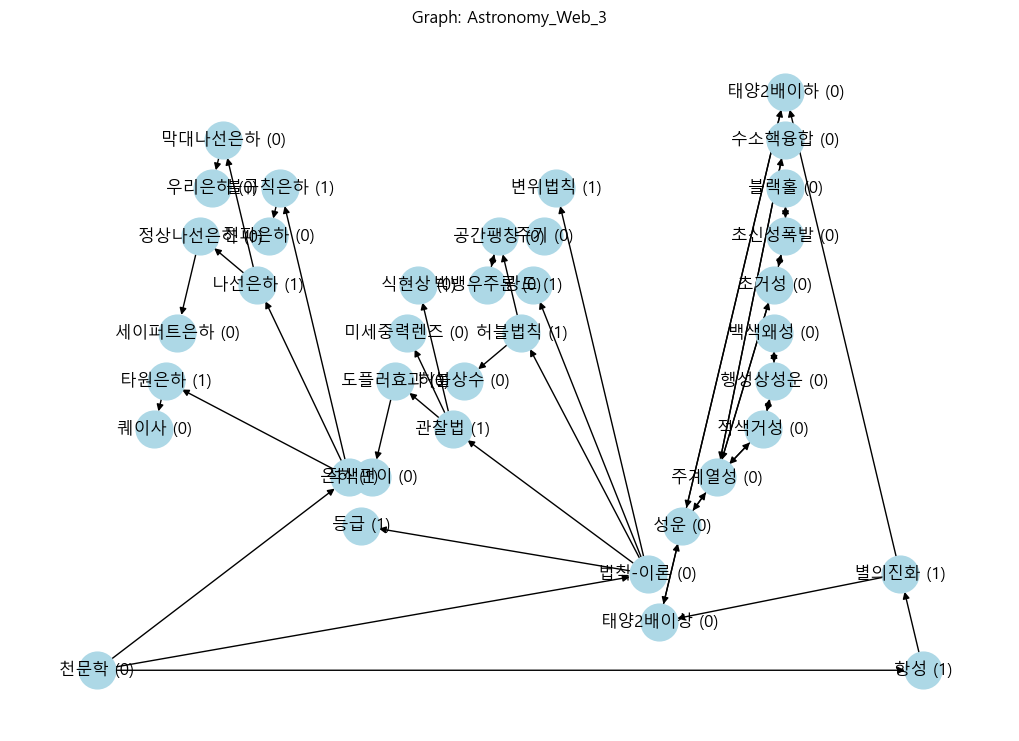

In [31]:
for graph_name, G in graphs_astrom.items():
    pos = nx.planar_layout(G)
    labels = {node: f"{node} ({G.nodes[node].get('P.Knowledge', 'N/A')})" for node in G.nodes()}
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='lightblue', font_family=font_name)
    plt.title(f"Graph: {graph_name}")
    plt.show()
    
    # For test
    if graph_name == 'Astronomy_Web_3':
        break